Import libraries needed for the classification. We'll be using MobileNetv2 due to its lightweighted nature and easiness to train.

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim

Next, we will need to load in the model from PyTorch. We will be performing transfer learning, so we will first load in the pretrained model and then use our own data to finetune it for surface classification. Also note that MobileNetv2 is a pretrained classfication neural network trained on 1000 classes, so we want to change the last layer of the model to perform a binary classification (paved and unpaved).

In [20]:
# Load the pretrained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the last fully connected layer
num_classes = 2  # Paved and Unpaved
model.classifier[1] = torch.nn.Linear(model.last_channel, num_classes)

# Freeze pretrained layers
for param in model.parameters():
    param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.


Next we will load in the training data and perform transforms on the data so that it can be processed by our model. Notice that MobileNetv2 takes in inputs of size 224 by 224.

In [21]:

# Define transforms to be applied to the training images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Prepare the training dataset (Assuming you have your dataset stored in a folder called 'train')
train_dataset = torchvision.datasets.ImageFolder('../data/rf_data/train/', transform=transform)

# Create the train_loader
batch_size = 32  # Number of images per batch
shuffle = True  # Shuffle the training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)


Next, we will define our optimization and loss function. For our optimizer we are using Adam and our loss is CrossEntropyLoss, typically used for multiclass classification.

In [22]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Below we have defined our training loop, which includes a validation function.

In [23]:
# Validate current model (check it's performance with the validation data)

# Define transforms to be applied to the validation images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Prepare the validation dataset (Assuming you have your dataset stored in a folder called 'valid')
valid_dataset = torchvision.datasets.ImageFolder('../data/rf_data/valid/', transform=transform)

# Create the validation_loader
batch_size = 32  # Number of images per batch
shuffle = True  # Shuffle the training data
validation_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle)

def validate():
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    average_loss = total_loss / len(validation_loader)

    print(f"Validation Loss: {average_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")

In [24]:

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.requires_grad_()  # Set requires_grad to True for images


        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    # Calculate average training loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")
    validate()

Epoch 1 Loss: 0.7363
Validation Loss: 0.7071
Validation Accuracy: 49.55%
Epoch 2 Loss: 0.7408
Validation Loss: 0.7011
Validation Accuracy: 47.73%
Epoch 3 Loss: 0.7487
Validation Loss: 0.6857
Validation Accuracy: 53.64%
Epoch 4 Loss: 0.7427
Validation Loss: 0.7124
Validation Accuracy: 48.64%
Epoch 5 Loss: 0.7356
Validation Loss: 0.6976
Validation Accuracy: 51.36%
Epoch 6 Loss: 0.7366
Validation Loss: 0.6963
Validation Accuracy: 52.27%
Epoch 7 Loss: 0.7298
Validation Loss: 0.6978
Validation Accuracy: 50.45%
Epoch 8 Loss: 0.7394
Validation Loss: 0.6985
Validation Accuracy: 50.00%
Epoch 9 Loss: 0.7430
Validation Loss: 0.7040
Validation Accuracy: 51.82%
Epoch 10 Loss: 0.7379
Validation Loss: 0.7004
Validation Accuracy: 51.36%


Here are some results using the VGG16 model classifier, with the 1000 images as training data. The data was augmented so the total data used for training and validation was around 3000.

Epoch 1 Loss: 0.6767
Validation Loss: 0.6749
Validation Accuracy: 59.09%
Epoch 2 Loss: 0.6814
Validation Loss: 0.6794
Validation Accuracy: 58.18%
Epoch 3 Loss: 0.6820
Validation Loss: 0.6787
Validation Accuracy: 59.09%
Epoch 4 Loss: 0.6768
Validation Loss: 0.6787
Validation Accuracy: 56.82%
Epoch 5 Loss: 0.6854
Validation Loss: 0.6764
Validation Accuracy: 57.27%
Epoch 6 Loss: 0.6839
Validation Loss: 0.6782
Validation Accuracy: 57.73%
Epoch 7 Loss: 0.6751
Validation Loss: 0.6797
Validation Accuracy: 57.73%
Epoch 8 Loss: 0.6756
Validation Loss: 0.6789
Validation Accuracy: 58.18%
Epoch 9 Loss: 0.6701
Validation Loss: 0.6761
Validation Accuracy: 61.36%
Epoch 10 Loss: 0.6818
Validation Loss: 0.6802
Validation Accuracy: 56.36%

When using the Mobilenetv2 model, we have slightly worse performance.
Epoch 1 Loss: 0.7363
Validation Loss: 0.7071
Validation Accuracy: 49.55%
Epoch 2 Loss: 0.7408
Validation Loss: 0.7011
Validation Accuracy: 47.73%
Epoch 3 Loss: 0.7487
Validation Loss: 0.6857
Validation Accuracy: 53.64%
Epoch 4 Loss: 0.7427
Validation Loss: 0.7124
Validation Accuracy: 48.64%
Epoch 5 Loss: 0.7356
Validation Loss: 0.6976
Validation Accuracy: 51.36%
Epoch 6 Loss: 0.7366
Validation Loss: 0.6963
Validation Accuracy: 52.27%
Epoch 7 Loss: 0.7298
Validation Loss: 0.6978
Validation Accuracy: 50.45%
Epoch 8 Loss: 0.7394
Validation Loss: 0.6985
Validation Accuracy: 50.00%
Epoch 9 Loss: 0.7430
Validation Loss: 0.7040
Validation Accuracy: 51.82%
Epoch 10 Loss: 0.7379
Validation Loss: 0.7004
Validation Accuracy: 51.36%

Alternatively, I have also trained a model using Roboflow and it's AutoML and the results are surprising. Roboflow claims that it has reached an accuracy of 99.1% using the same 1000 images. One reason that this model might be superior is that it trains images on the original sized images (after the crop), while the other models take 224 x 224 images input, which may heavily reduce the information present in those images.

In [25]:
from roboflow import Roboflow

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access the API key from the environment variable
api_key = os.getenv('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=api_key)
project = rf.workspace().project("road-surface-classification-lgxl1")
model = project.version(1).model

print(model)

loading Roboflow workspace...
loading Roboflow project...
{
  "name": "Road Surface Classification",
  "version": "1",
  "base_url": "https://classify.roboflow.com/"
}


Here are some training graphs from the Roboflow model

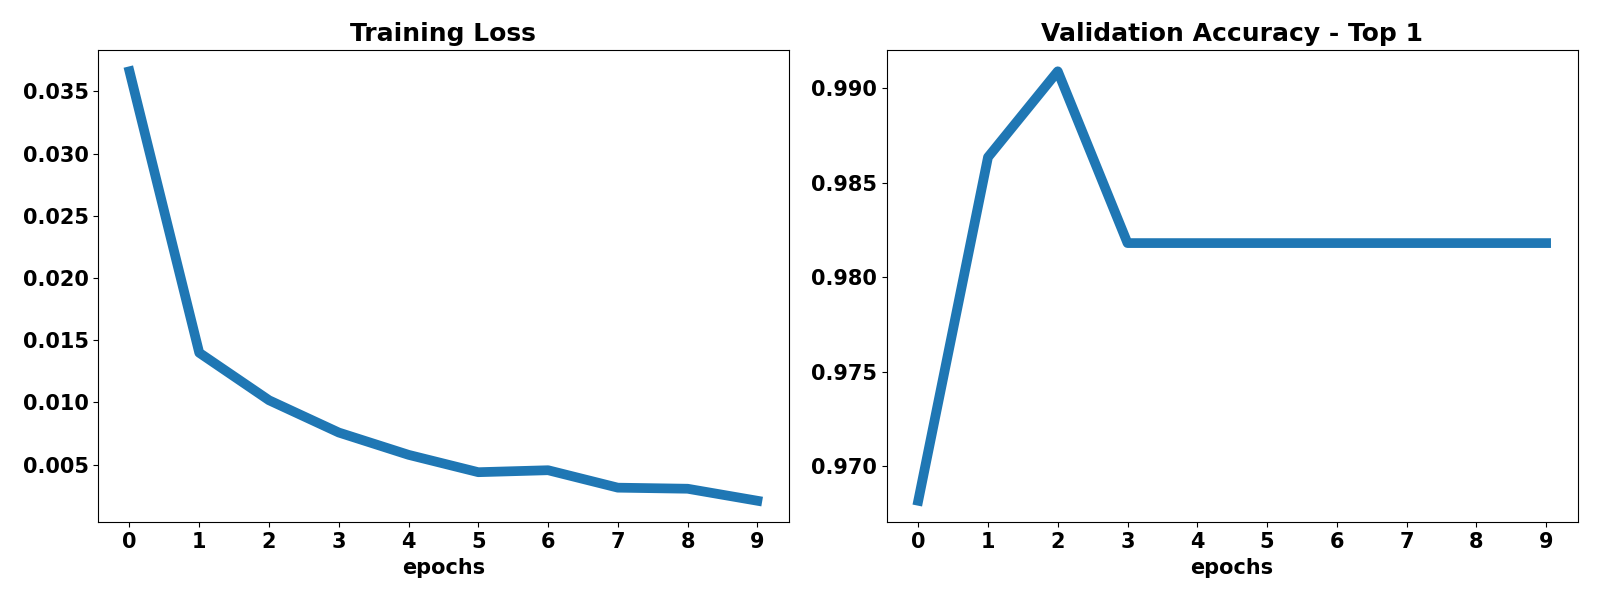

In [4]:
from IPython.display import Image

# Path to the image file
image_path = 'train_loss.png'

# Display the image
Image(filename=image_path)